In [1]:
!nvidia-smi

Fri Feb 13 23:29:59 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.86                 Driver Version: 591.86         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              1W /  105W |     502MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, Input,
    RandomFlip, RandomRotation, RandomZoom, Rescaling
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report, f1_score
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [3]:
training_set = image_dataset_from_directory(
    'train',
    image_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7316 files belonging to 4 classes.


In [4]:
validation_set = image_dataset_from_directory(
    'valid',
    image_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=0.5,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1829 files belonging to 4 classes.
Using 915 files for training.


In [5]:
test_set = image_dataset_from_directory(
    'valid',
    image_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=0.5,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1829 files belonging to 4 classes.
Using 914 files for validation.


In [6]:
class_names = training_set.class_names
print(class_names)

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']


In [7]:
class_counts = np.zeros(len(class_names))

for images, labels in training_set:
    for label in labels:
        class_counts[label.numpy()] += 1

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {int(class_counts[i])}")


Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642
Corn_(maize)___Common_rust_: 1907
Corn_(maize)___Northern_Leaf_Blight: 1908
Corn_(maize)___healthy: 1859


In [8]:
class_counts = np.zeros(len(class_names))

for images, labels in validation_set:
    for label in labels:
        class_counts[label.numpy()] += 1

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {int(class_counts[i])}")


Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 215
Corn_(maize)___Common_rust_: 226
Corn_(maize)___Northern_Leaf_Blight: 238
Corn_(maize)___healthy: 236


In [9]:
class_counts = np.zeros(len(class_names))

for images, labels in test_set:
    for label in labels:
        class_counts[label.numpy()] += 1

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {int(class_counts[i])}")


Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 195
Corn_(maize)___Common_rust_: 251
Corn_(maize)___Northern_Leaf_Blight: 239
Corn_(maize)___healthy: 229


In [10]:
print(training_set)
print(validation_set)
print(test_set)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [11]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = len(class_names)

model = Sequential([
    Input(shape=(224, 224, 3)),

    data_augmentation,
    Rescaling(1./255),

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax')
])

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.build(input_shape=(None, 224, 224, 3))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)     

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'Corn_custom_cnn_best_final.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [18]:
training_history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
458/458 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8600
Epoch 1: val_accuracy improved from -inf to 0.73552, saving model to Corn_custom_cnn_best_final.keras
458/458 [==============================] - 69s 112ms/step - loss: 0.4008 - accuracy: 0.8600 - val_loss: 0.5259 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 2/30
458/458 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9177
Epoch 2: val_accuracy did not improve from 0.73552
458/458 [==============================] - 51s 111ms/step - loss: 0.2362 - accuracy: 0.9177 - val_loss: 0.9937 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 3/30
458/458 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9271
Epoch 3: val_accuracy improved from 0.73552 to 0.78579, saving model to Corn_custom_cnn_best_final.keras
458/458 [==============================] - 48s 106ms/step - loss: 0.1916 - accuracy: 0.9271 - val_loss: 0.5735 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 4/30
45

In [19]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


📈 Training history:



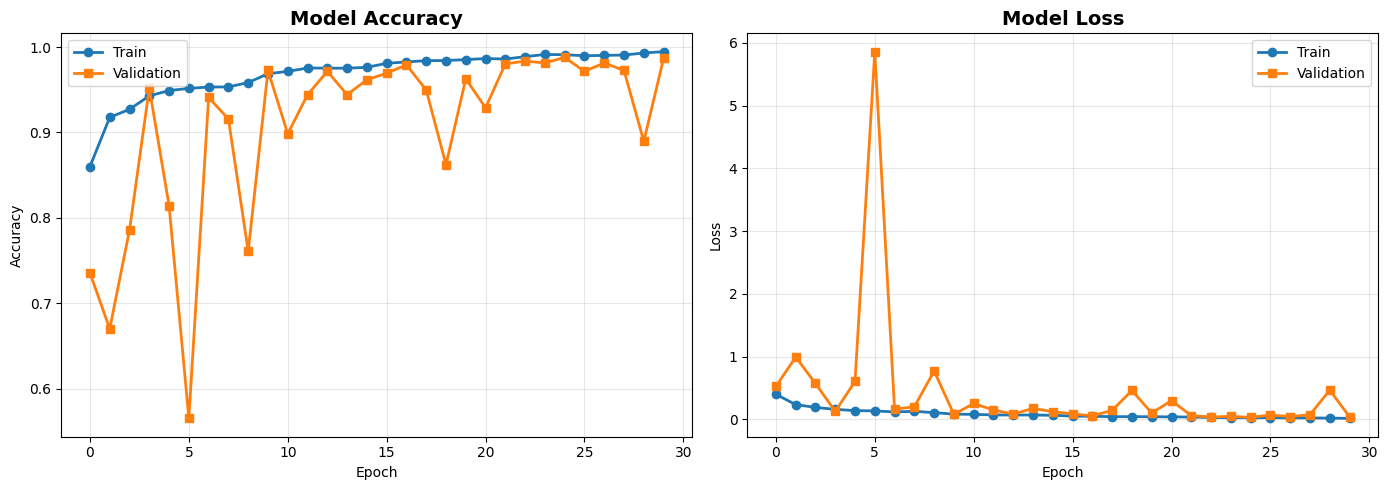


📊 FINAL METRICS:
   Best Train Accuracy: 0.9947 (99.47%)
   Best Val Accuracy: 0.9880 (98.80%)
   Best Val Loss: 0.0331
   Target ≥98.5%: ACHIEVED ✅


In [20]:
print("\n📈 Training history:\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(training_history.history['accuracy'], label='Train', linewidth=2, marker='o')
axes[0].plot(training_history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(training_history.history['loss'], label='Train', linewidth=2, marker='o')
axes[1].plot(training_history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Model_acc_model_loss.png', dpi=800)
plt.show()


# Final metrics
best_val_acc = max(training_history.history['val_accuracy'])
best_train_acc = max(training_history.history['accuracy'])
final_val_loss = min(training_history.history['val_loss'])

print(f"\n📊 FINAL METRICS:")
print(f"   Best Train Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"   Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Val Loss: {final_val_loss:.4f}")
print(f"   Target ≥98.5%: {'ACHIEVED ✅' if best_val_acc >= 0.985 else 'IN PROGRESS ⏳'}")

In [21]:
print(max(training_history.history['accuracy']))
print(max(training_history.history['val_accuracy']))
print(min(training_history.history['loss']))
print(min(training_history.history['val_loss']))

0.9946691989898682
0.9879781603813171
0.01654565893113613
0.03314874321222305



📊 Evaluating model on Validation...

58/58 [==============================] - 2s 22ms/step
📋 CLASSIFICATION REPORT (VALIDATION)
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9635    0.9814    0.9724       215
                       Corn_(maize)___Common_rust_     1.0000    0.9956    0.9978       226
               Corn_(maize)___Northern_Leaf_Blight     0.9830    0.9706    0.9767       238
                            Corn_(maize)___healthy     1.0000    1.0000    1.0000       236

                                          accuracy                         0.9869       915
                                         macro avg     0.9866    0.9869    0.9867       915
                                      weighted avg     0.9870    0.9869    0.9869       915


🎯 Weighted F1 Score: 0.9869
📊 Overall Accuracy:  0.9869


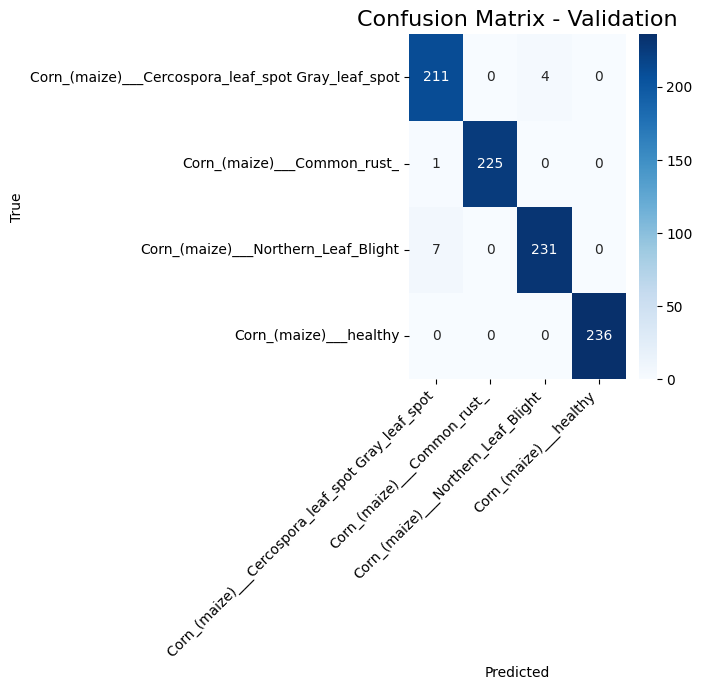


📊 Evaluating model on Test...

58/58 [==============================] - 1s 22ms/step
📋 CLASSIFICATION REPORT (TEST)
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9691    0.9641    0.9666       195
                       Corn_(maize)___Common_rust_     0.9960    1.0000    0.9980       251
               Corn_(maize)___Northern_Leaf_Blight     0.9707    0.9707    0.9707       239
                            Corn_(maize)___healthy     1.0000    1.0000    1.0000       229

                                          accuracy                         0.9847       914
                                         macro avg     0.9840    0.9837    0.9838       914
                                      weighted avg     0.9847    0.9847    0.9847       914


🎯 Weighted F1 Score: 0.9847
📊 Overall Accuracy:  0.9847


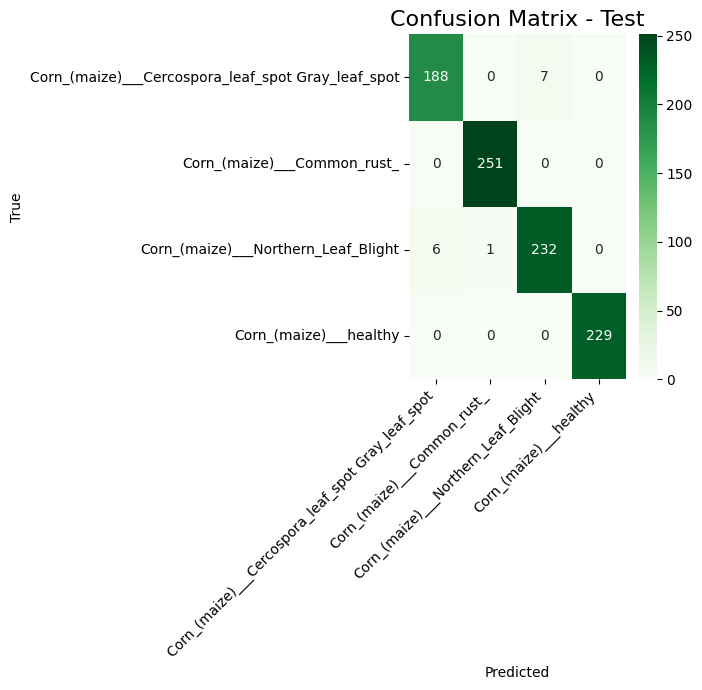


📊 FINAL SUMMARY

🔵 VALIDATION:
   Accuracy: 0.9869
   F1 Score: 0.9869

🟢 TEST:
   Accuracy: 0.9847
   F1 Score: 0.9847

Gap: 0.0022 ✅ Excellent generalization


In [22]:
def evaluate_dataset(model, dataset, class_names, dataset_name="Dataset", cmap="Blues"):
    
    print(f"\n📊 Evaluating model on {dataset_name}...\n")
    pred_probs = model.predict(dataset, verbose=1)
    y_pred = np.argmax(pred_probs, axis=1)

    y_true = tf.concat([y for x, y in dataset], axis=0).numpy()

    # Classification Report
    print("="*80)
    print(f"📋 CLASSIFICATION REPORT ({dataset_name.upper()})")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = (y_pred == y_true).mean()

    print(f"\n🎯 Weighted F1 Score: {f1:.4f}")
    print(f"📊 Overall Accuracy:  {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower()}.png', dpi=800)
    plt.show()

    return f1, acc


val_f1, val_acc = evaluate_dataset(model, validation_set, class_names, "Validation", "Blues")
test_f1, test_acc = evaluate_dataset(model, test_set, class_names, "Test", "Greens")


print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

print(f"\n🔵 VALIDATION:")
print(f"   Accuracy: {val_acc:.4f}")
print(f"   F1 Score: {val_f1:.4f}")

print(f"\n🟢 TEST:")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   F1 Score: {test_f1:.4f}")

gap = abs(val_f1 - test_f1)

if gap < 0.02:
    print(f"\nGap: {gap:.4f} ✅ Excellent generalization")
elif gap < 0.05:
    print(f"\nGap: {gap:.4f} ⚠️ Acceptable")
else:
    print(f"\nGap: {gap:.4f} ❌ Possible overfitting")

print("="*80)


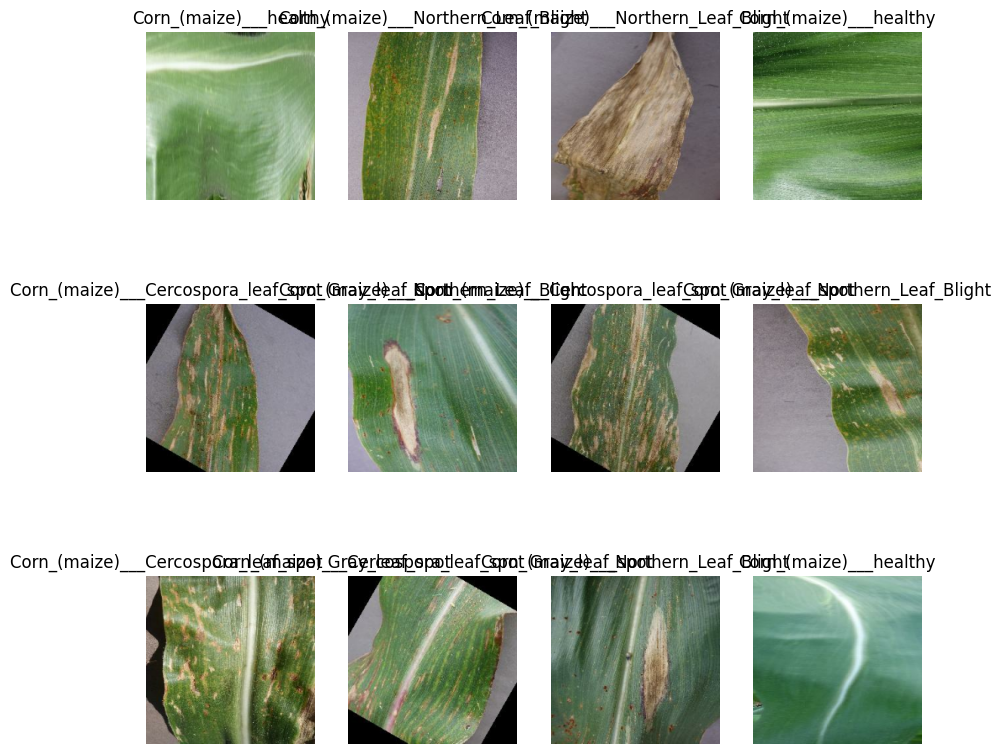

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

first image to predict
actual label: Corn_(maize)___healthy
1/1 [==============================] - 0s 121ms/step
predicted label: Corn_(maize)___healthy


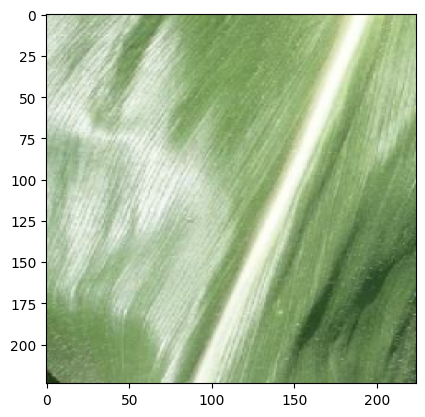

In [24]:
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


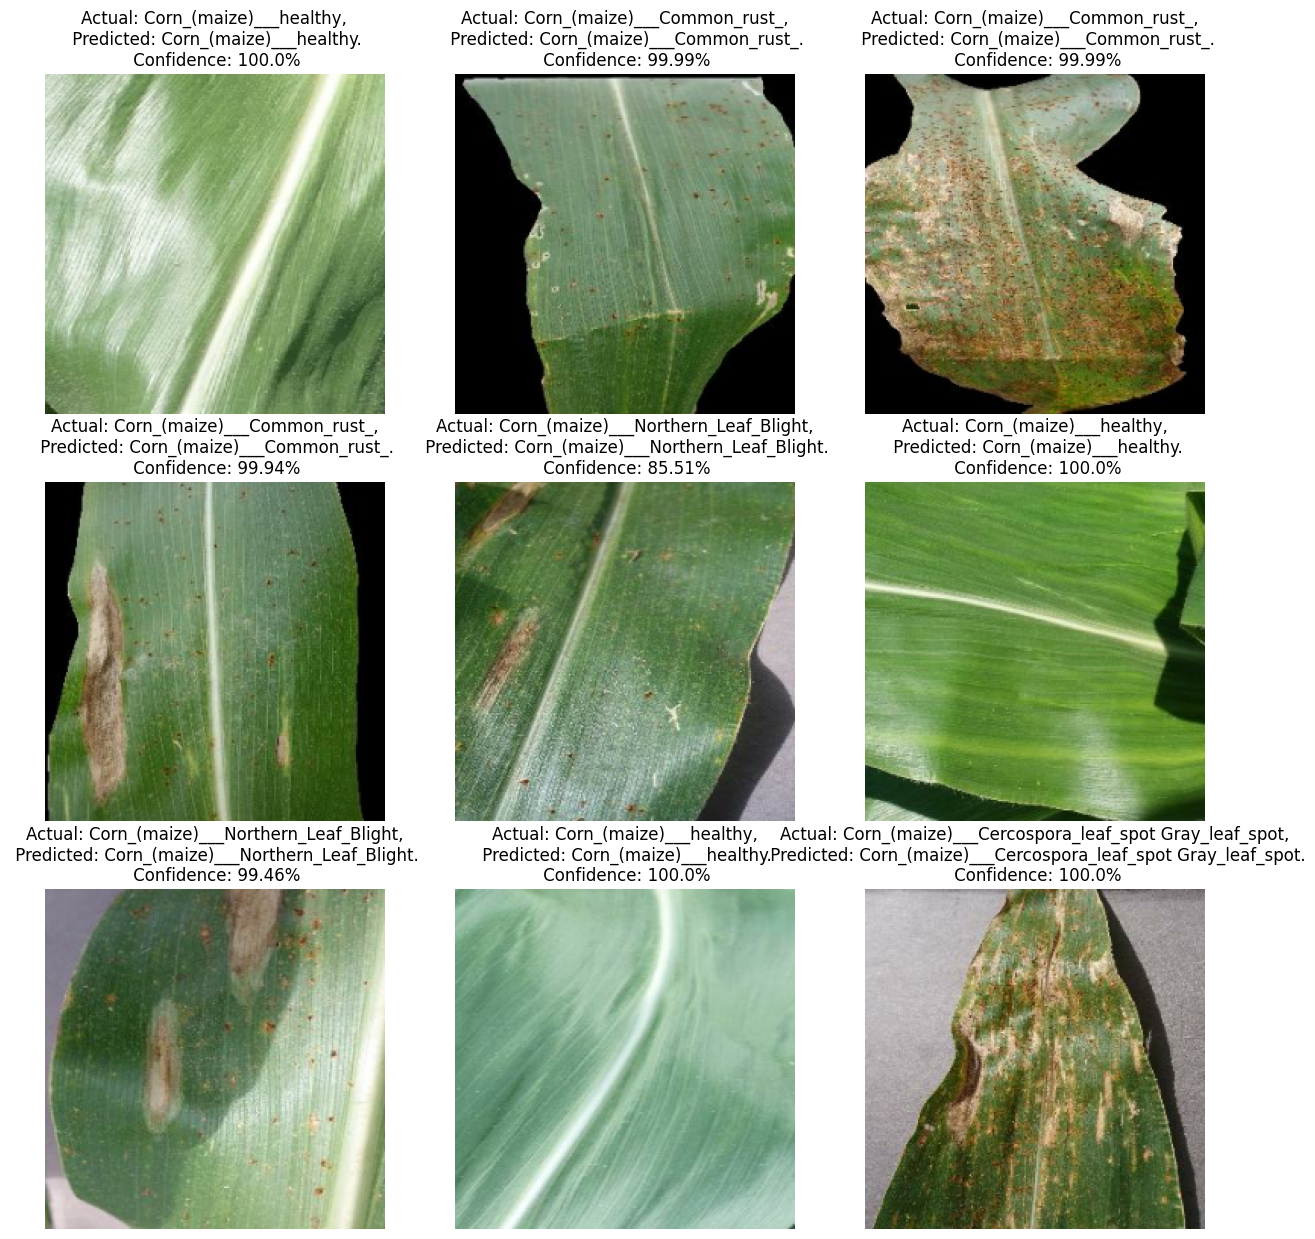

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
model.save_weights('Corn_model_weights_final_vg.h5')
model.save('Corn_custom_cnn_best_final_vg.keras')